In [0]:
import numpy as np
import mnist
import matplotlib.pyplot as plt
import math

In [2]:
mnist.init()
x_train, t_train, x_test, t_test = mnist.load()

Download complete.
Save complete.


## Output and Loss 
We define the output function as the softmax function and the loss function we are trying to minimize as the cross entropy loss.

In [0]:
def softmax(z):
  return np.exp(z)/np.sum(np.exp(z), axis=1, keepdims=True)

def cross_entropy_loss(predicted, targets):
  logPT = 0
  for i in range(10):
    if (targets[i] == 1): logPT = logPT + -np.log(predicted[i]+1e-10)
    else: logPT = logPT + -np.log(1 - predicted[i] + 1e-10)
  return logPT

## Utility Functions
## get_batches()
We define the function get_batches that returns and equal sized subsets of our input data.
## clip()
We clip the input given to the softmax function at a specified threshold. This fixes the stability issue when using the softmax function.

In [0]:
def get_batches(batch_size, X, y):
  batches_train = []
  batches_target = []
  for i in range(0, len(X), batch_size):
    batches_train.append(X[i:i+batch_size])
    batches_target.append(y[i:i+batch_size])
  return batches_train, batches_target

In [0]:
def clip(z, thresh):
  for i in range(z.shape[0]):
    for j in range(z.shape[1]):
      if (math.isnan(z[i][j])):
        z[i][j] = thresh
      elif (z[i][j] > thresh):
        z[i][j] = thresh
      elif (z[i][j] < -thresh):
        z[i][j] = -thresh

## init_weights()
Initializes the weights of the network.
## init_momentum()
Initializes the momentum used for training the network.
## shuffle_data()
Shuffles our training data.


In [0]:
def init_weights(layer_units_1, layer_units_2):
  np.random.seed(1)
  w0 = np.random.randn(784, layer_units_1)*np.sqrt(2/784)
  w1 = np.random.randn(layer_units_1, layer_units_2)*np.sqrt(2/(layer_units_1+layer_units_2))
  w2 = np.random.randn(layer_units_2,10)*np.sqrt(2/(layer_units_1+784))
  return w0, w1, w2

def init_momentum(layer_units_1, layer_units_2):
  V_0 = np.zeros((784, layer_units_1))
  V_1 = np.zeros((layer_units_1, layer_units_2))
  V_2 = np.zeros((layer_units_2, 10))
  return V_0, V_1, V_2

def shuffle_data(X, y, num_examples):
  shuffled_idx_train = np.random.permutation(num_examples)
  shuffled_idx_test = np.random.permutation(X.shape[0]-num_examples)
  training_samples, training_targets = X[shuffled_idx_train], y[shuffled_idx_train]
  
  shuffled_idx_test += (num_examples-1)
  test_samples, test_targets = X[shuffled_idx_test], y[shuffled_idx_test]
  return training_samples, training_targets, test_samples, test_targets

# The forward propagation for out 2-layer network
def forward_prop(inputs, targets, w0, w1, w2, b0, b1, b2):
  t = np.dot(inputs, w0) + b0   # linear transform layer 0
  h = np.maximum(t, 0)          # activation layer 1
  g = np.dot(h, w1) + b1        # linear transform layer 1
  f = np.maximum(g, 0)          # activation layer 2
  z = np.dot(f, w2) + b2        # linear transform layer 2
  clip(z, 16)                   # stability fix for softmax
  out = softmax(z)              # output
  return out, f, h

# The cross entropy loss on a single batch when training
def batch_loss(predicted, actual):
  loss = 0
  for i in range(len(predicted)):
    loss = loss + (cross_entropy_loss(predicted[i], actual[i]))
  return loss

# Added regularization to loss function
def L2_output_loss(reg, weight1, weight2, weight3):
    weight1_loss = (reg/2.0) * np.sum(weight1 * weight1)
    weight2_loss = (reg/2.0) * np.sum(weight2 * weight2)
    weight3_loss = (reg/2.0) * np.sum(weight3 * weight3)
    return weight1_loss + weight2_loss + weight3_loss

# Computes the error of the outputs for a single batch
def batch_error(predicted, actual):
  error = (predicted - actual) / predicted.shape[0]                   
  return error

# These three functions compute the gradients for the three layers in the 
# 2-layer neural network
def gradient_layer2_weights(errors, h2):
  return np.dot(h2.T, errors)

def gradient_layer1_weights(errors, second_layer_weights, h2, h1):
  dL_df = errors.dot(second_layer_weights.T)
  dL_df[h2 <= 0] = 0                    # element-wise multiplication of deriv
  dL_dg = dL_df
  dL_dw1 = dL_dg.T.dot(h1)
  return dL_dw1, np.sum(dL_df, axis=0, keepdims=True)

def gradient_layer0_weights(batch, errors, l2_weights, l1_weights, h2, h1):
  dL_df = np.dot(errors, l2_weights.T)
  dL_df[h2 <= 0] = 0                   
  dL_dg = np.dot(dL_df, l1_weights.T)
  dL_dg[h1 <= 0] = 0                   
  dL_dw0 = np.dot(batch.T, dL_dg)
  return dL_dw0, np.sum(dL_dg, axis=0, keepdims=True)

In [0]:
def predict(X, t, batch_size, weights_0, weights_1, weights_2, b0, b1, b2):
  
  X = np.array(X)
  t = np.array(t)
  predictions = []
  batches_test_input, batches_test_target = get_batches(batch_size, X, t)
  
  test_loss = 0
  for batch in range(len(batches_test_input)):
    t = np.dot(batches_test_input[batch], weights_0) + b0
    h = np.maximum(t, 0)             
    g = np.dot(h, weights_1) + b1         
    f = np.maximum(g, 0)            
    z = np.dot(f, weights_2) + b2 
    out = softmax(z)              
    test_loss = test_loss + batch_loss(out, batches_test_target[batch])
    
    for pred in range(len(out)):
      predictions.append(out[pred])
    
  return predictions, test_loss

## Training algorithm for the 2-layer network

In [0]:
def train_network(X, y, num, batch_size, learning_rate, decay, beta, epochs, layer_units_1, layer_units_2):
    
    loss_all = []
    all_epochs = []
    test_loss = []
    
    # weight initialization
    w0, w1, w2 = init_weights(layer_units_1, layer_units_2)
    
    # biases initialization
    b0 = 0 
    b1 = 0 
    b2 = 0
        
    # initialization of momentum values
    V_0, V_1, V_2 = init_momentum(layer_units_1, layer_units_2)
        
    # shuffle data
    X_train, y_train, X_test, y_test = shuffle_data(X, y, num)
    
    # get mini-batches
    batches_train, batches_target = get_batches(batch_size, X_train, y_train)
    
    # SGD/mini-batch
    overall_loss = 0
    for epoch in range(0, epochs):
      
      # decay the learning_rate
      if (epoch % 10 == 0): learning_rate -= decay
        
      overall_loss = 0
      print("EPOCH:", epoch)
      all_epochs.append(epoch)
      
      # validation
      preds, t_loss = predict(X_test, y_test, batch_size, w0, w1, w2, b0, b1, b2)
      
      for batch in range(len(batches_train)):
        
                              ## FORWARD PROPAGATION ##
        
        out, hidden_l2, hidden_l1 = forward_prop(batches_train[batch], 
                                                 batches_target[batch],
                                                 w0,
                                                 w1,
                                                 w2,
                                                 b0,
                                                 b1,
                                                 b2)
       
        # loss for batch
        overall_loss = overall_loss + batch_loss(out, batches_target[batch])
        overall_loss += L2_output_loss(0.5, w0, w1, w2)
        
        # batch error
        errors = batch_error(out, batches_target[batch])
            
                              ## COMPUTE GRADIENTS ##
                
        dw2 = gradient_layer2_weights(errors, hidden_l2)
        db2 = np.sum(errors, axis=0, keepdims=True)
        dw1, db1 = gradient_layer1_weights(errors, 
                                      w2, 
                                      hidden_l2, 
                                      hidden_l1)
        dw0, db0 = gradient_layer0_weights(batches_train[batch],
                                      errors,
                                      w2,
                                      w1,
                                      hidden_l2,
                                      hidden_l1)
        
        # apply momentum
        V_0 = beta * V_0 + (1-beta)*dw0
        V_1 = beta * V_1 + (1-beta)*dw1.T
        V_2 = beta * V_2 + (1-beta)*dw2
       
        # update weights and biases
        w2 -= learning_rate*V_2
        w1 -= learning_rate*V_1
        w0 -= learning_rate*V_0
        
        b2 -= learning_rate*db2
        b1 -= learning_rate*db1
        b0 -= learning_rate*db0
                
      print("LOSS:", overall_loss/X_train.shape[0])
      loss_all.append(overall_loss / X_train.shape[0])
      test_loss.append(t_loss / X_test.shape[0])
      
    return w0, w1, w2, b0, b1, b2, loss_all, test_loss, all_epochs
      

In [0]:

# normalize training data
x_train = x_train / 255
# one-hot encoding of targets
training_targets = []
for t in range(0, 60000):
  y_t = np.zeros(10)
  y_t[t_train[t]] = 1
  training_targets.append(y_t)

training_targets = np.array(training_targets)

In [0]:
l_rate = 0.01
decay = 0
batch_nu = 200
epochs = 50
hidden_units_1 = 300
hidden_units_2 = 200
num_examples = 60000
training_nu = 50000
m_rate = 0.9
training_data = x_train[:num_examples]
target_data = training_targets[:num_examples]
weight0, weight1, weight2, b0, b1, b2, loss, test_loss, iters = train_network(
                                                       training_data, 
                                                       target_data, 
                                                       training_nu,
                                                       batch_nu,
                                                       l_rate,
                                                       decay,
                                                       m_rate, 
                                                       epochs, 
                                                       hidden_units_1,
                                                       hidden_units_2
                                                       )

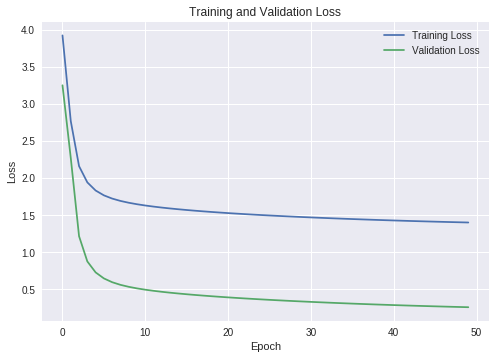

In [11]:
plt.plot(iters, loss, label='Training Loss')
plt.plot(iters, test_loss, label='Validation Loss')
plt.title("Training and Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [0]:
# normalize test input
x_test = x_test / 255

# one-hot encoding of targets for test
test_targets = []
for t in range(0, 10000):
  y_t = np.zeros(10)
  y_t[t_test[t]] = 1
  test_targets.append(y_t)

preds, t = predict(x_test, test_targets, batch_nu, weight0, weight1, weight2, b0, b1, b2)

In [0]:
# One-hot encodings of predictions
for i in range(len(preds)):
  for j in range(len(preds[i])):
      preds[i][j] = int(round(preds[i][j]))

In [0]:
# Test trained model
correct = 0
for i in range(len(preds)):
  if ( (preds[i] != test_targets[i]).any() ):
    continue
  else:
    correct = correct + 1

In [15]:
print("TEST ACCURACY: ")
print( 100 * (correct / 10000) )

TEST ACCURACY: 
94.62


## Explanation
After some experiments, the training was done witha learning rate of 0.01, batch sizes of 200, and 60,000 samples (50,000 for training and 10,000 for validation/test). The architecture is a feed-forward neural network with two hidden ReLU layers, the first hidden layer containing 300 neurons and the second hidden layer containing 200 neurons. The training was done for 50 epochs. The negative log-likelihood is used to maximize the maximum likelihood function. As the figure shows above, the negative log-likelihood is clearly minimized the longer we train the network. Momentum was used to speed up the stochastic gradient descent, which was used to update the weights of the network. For each epoch of training, we test the current model by evaluating the loss on a chunk of the training data that we did not use for training. This is the validation loss and should decrease along with the training loss, which is the case as the figure above shows. 

## Overfitting

In [0]:
def forward_prop_singleLayer(inputs, targets, weight1, weight2, bias1, bias2):
  first = np.dot(inputs, weight1) + bias1
  activ = np.maximum(first, 0)
  second = np.dot(activ, weight2) + bias2
  clip(second, 16)
  output = softmax(second)
  loss = batch_loss(output, targets) + L2_output_loss(0.5, weight1, weight2, 0)
  return output, activ, loss

def predict_singleLayer_network(data, t, b_size, w1, w2, b1, b2):
  test_input, test_target = get_batches(b_size, data, t)
  all_loss = 0
  predictions = []
  for batch in range(len(test_input)):
    out, _, test_loss = forward_prop_singleLayer(test_input[batch],
                                                 test_target[batch],
                                                 w1,
                                                 w2,
                                                 b1,
                                                 b2)
    all_loss += test_loss
    
    for i in range(len(out)):
      predictions.append(out[i])
      
  return predictions, (all_loss / data.shape[0])


def single_layer_network(data, t, l_rate, b_size, tr_num, hidd_nu, beta, epchs):
  w1, _, w2= init_weights(hidd_nu, hidd_nu)
  v1, _, v2 = init_momentum(hidd_nu, hidd_nu)
  b1 = 0
  b2 = 0
  val_loss_per_epoch = []
  training_loss_per_epoch = []
  all_epochs = []
  
  X_tr, y_tr, X_t, y_t = shuffle_data(data, t, tr_num)
  batches_x_tr, batches_y_tr = get_batches(b_size, X_tr, y_tr)
  
  for epoch in range(epchs):
    
    all_epochs.append(epoch)
    overall_loss_epoch = 0
    _, test_loss = predict_singleLayer_network(X_t, y_t, b_size, w1, w2, b1, b2)
    val_loss_per_epoch.append(test_loss)
    
    for batch in range(len(batches_x_tr)):
      out, h, loss = forward_prop_singleLayer(batches_x_tr[batch],
                                              batches_y_tr[batch],
                                              w1,
                                              w2,
                                              b1,
                                              b2)
      
      overall_loss_epoch += loss 
      errors = batch_error(out, batches_y_tr[batch])
      
      dw2 = gradient_layer2_weights(errors, h)
      dw2 += 0.01*w2
      db2 = np.sum(errors, axis=0, keepdims=True)
      dw1, db1 = gradient_layer1_weights(errors, 
                                      w2, 
                                      h, 
                                      batches_x_tr[batch])
      dw1 += 0.01*w1.T
      
      v1 = beta*v1 + (1-beta)*dw1.T
      v2 = beta*v2 + (1-beta)*dw2
      
      w1 -= l_rate*dw1.T
      w2 -= l_rate*dw2
      
      b1 -= l_rate*db1
      b2 -= l_rate*db2
    
    
    training_loss_per_epoch.append(overall_loss_epoch/tr_num)
    
  return training_loss_per_epoch, val_loss_per_epoch, all_epochs

In [0]:
# normalize test input
x_test = x_test / 255

# one-hot encoding of targets for test
t_targets = []
for t in range(0, 10000):
  y_t = np.zeros(10)
  y_t[t_test[t]] = 1
  t_targets.append(y_t)
t_targets = np.array(t_targets)



In [0]:
# one-hot encoding of targets
targets = []
for t in range(0, 60000):
  y_t = np.zeros(10)
  y_t[t_train[t]] = 1
  targets.append(y_t)
targets = np.array(targets)                                         

In [0]:
inputs = x_test[:6000]
t = targets[:6000]
learning_rate = 0.01
batch_size = 10
number_to_train = 10
hidden_nu = 10
momentum = 0.9
epochs = 500
training_loss, val_loss, all_epochs = single_layer_network(inputs, t, 
                                                           learning_rate, 
                                                           batch_size,
                                                           number_to_train,
                                                           hidden_nu,
                                                           momentum,
                                                           epochs)

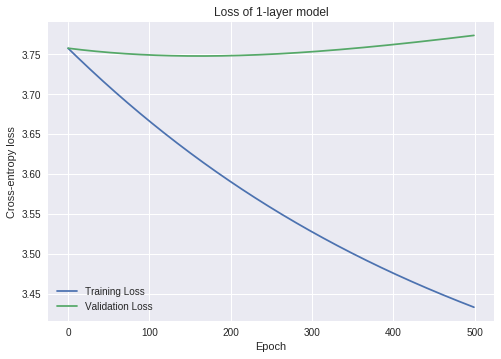

In [20]:
plt.plot(all_epochs, training_loss, label="Training Loss")
plt.plot(all_epochs, val_loss, label="Validation Loss")
plt.title("Loss of 1-layer model")
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy loss")
plt.legend()
plt.show()

Overfitting occurs when the network is able to attain a a low loss on a training set of data, but when used on the test data the loss increases with the more epochs of training on the training data. Given a small subset of the training data (10 samples) it is shown above that a 1-layer model can achieve a low loss with enough training. Generally, if we take a small subset of the training data and do "a lot" of training on that data the model will not generalize well and will then perform poorly when tested on the test data, leading to an increased loss on the test data with the more epochs of training we do. It is better to train on a data set that that better represents the distribution of the whole data set that way the model generalizes better.